In [2]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import logging

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    SPLIT,
    DEVELOP,
    TEST
)

sns.set_style("darkgrid")
matplotlib.rcParams['font.family'] = "serif"
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [3]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Genera...,[regulatory standards management]
1,General Quality System Requirements […] Manage...,"[quality planning, quality management]"
2,General Quality System Requirements […] Manage...,[quality management]


In [4]:
features = Features(config)
df_features = features.build(df)

2022-10-31 19:15:09,555 - capstone.utils.utils - INFO - func:clean took: 3.18 sec
2022-10-31 19:15:10,216 - capstone.utils.utils - INFO - func:fit took: 3.84 sec
2022-10-31 19:15:12,149 - capstone.utils.utils - INFO - func:clean took: 1.93 sec
2022-10-31 19:15:12,398 - capstone.utils.utils - INFO - func:transform took: 2.18 sec
2022-10-31 19:15:12,398 - capstone.utils.utils - INFO - func:fit_transform took: 6.03 sec
2022-10-31 19:15:12,615 - capstone.utils.utils - INFO - func:clean took: 0.22 sec
2022-10-31 19:15:12,644 - capstone.utils.utils - INFO - func:transform took: 0.25 sec
2022-10-31 19:15:12,671 - capstone.utils.utils - INFO - func:build took: 6.31 sec


In [5]:
df_features.head(3)

,Text,Standard mapping?,acquisition and divestiture,audit inspection,calibration,capa,change control,change controls,clinical research,controled substances,...,word__unit generally shared,word__use device,word__used manufacture,word__used manufacturing,word__used production,word__user person,word__validation study,word__way ensures,word__written procedure,Split
0,drug product general design formal stability s...,[stability programs],0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development
1,quality control quality assurance management q...,[production process controls],0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development
2,manufacturing control packaging operation ensu...,[labeling and packaging operations],0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development


In [6]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
X_dev = dev[features.vectorizer.get_feature_names_out()].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
X_test = test[features.vectorizer.get_feature_names_out()].copy()
Y_test = test[features.mlb.classes_].copy()

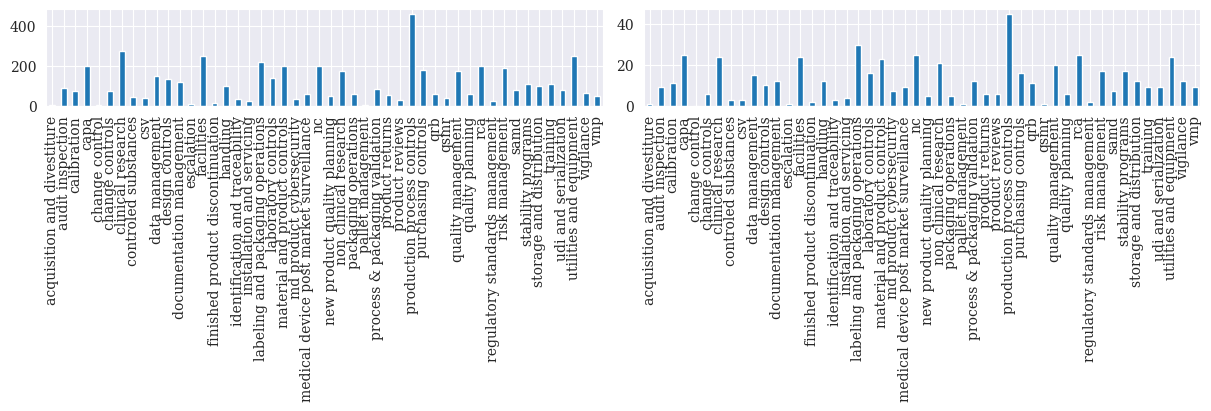

In [7]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0]);
Y_test.sum(axis=0).plot.bar(ax=ax[1]);

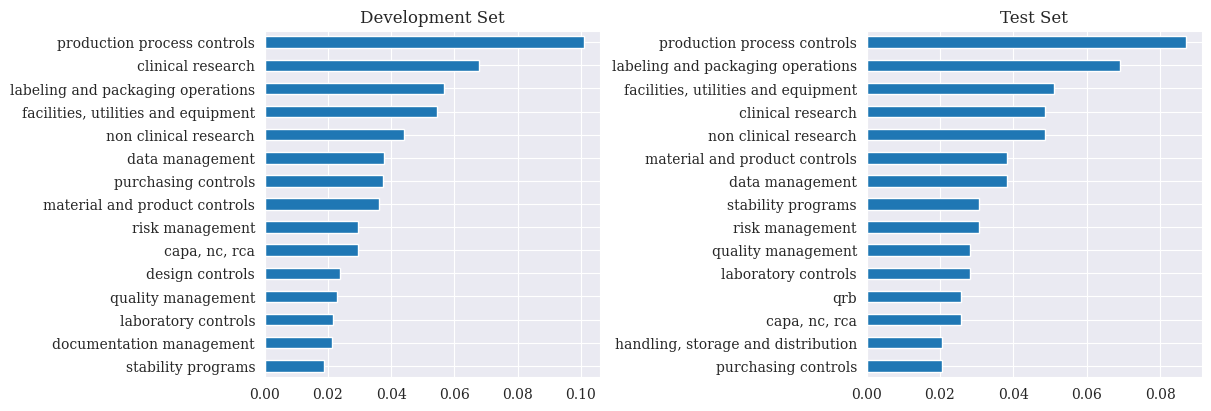

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

dev[TARGET] \
.apply(lambda x: ", ".join(sorted(x))) \
.value_counts(normalize=True) \
.head(15) \
.sort_values() \
.plot(kind="barh", ax=ax[0])

test[TARGET] \
.apply(lambda x: ", ".join(sorted(x))) \
.value_counts(normalize=True) \
.head(15) \
.sort_values() \
.plot(kind="barh", ax=ax[1])

ax[0].set_title("Development Set")
ax[1].set_title("Test Set")
plt.show();

In [9]:
eval = CustomEvaluation()

Naive Model - Predict the most popular target (binary vector) in the development set

In our case, the most popular development target matches the most popular test target.

In [10]:
most_popular = \
    dev.groupby(by=features.mlb.classes_.tolist(), as_index=False) \
    .size() \
    .sort_values(by="size", ascending=False) \
    .apply(lambda row: np.array(row[features.mlb.classes_.tolist()]), axis=1) \
    .values[0]

print(
    "Most popular binary vector in development set:",
    features.mlb.inverse_transform(most_popular.reshape(1, -1))
)

Y_test_pred = np.tile(most_popular, (Y_test.shape[0] , 1))

Most popular binary vector in development set: [('production process controls',)]


In [11]:
eval.compute_sample_wise_metrics(y_true=Y_test.to_numpy(), y_pred=Y_test_pred)

Hamming Loss    0.046569
Accuracy        0.086957
Precision       0.115090
Recall          0.096441
F1 Score        0.100824
dtype: float64

In [12]:
cmat = eval.compute_multilabel_confusion_matrix(
    y_true=Y_test.to_numpy(), y_pred=Y_test_pred, labels=features.mlb.classes_
)
cmat.style.set_table_styles(config.CONFUSION_MATRIX_STYLER)

In [13]:
eval.compute_label_wise_metrics(
    y_true=Y_test.to_numpy(),
    y_pred=Y_test_pred,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,Development Samples,Test Samples
acquisition and divestiture,0.00000,0.0,0.000000,5,1
audit inspection,0.00000,0.0,0.000000,87,9
calibration,0.00000,0.0,0.000000,73,11
capa,0.00000,0.0,0.000000,199,25
change control,0.00000,0.0,0.000000,4,0
change controls,0.00000,0.0,0.000000,72,6
clinical research,0.00000,0.0,0.000000,274,24
controled substances,0.00000,0.0,0.000000,43,3
csv,0.00000,0.0,0.000000,37,3
data management,0.00000,0.0,0.000000,148,15
